In [2]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [3]:
import numpy as numpy
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib


# Set up paths for images

In [34]:
data_dir = pathlib.Path('C:\\Users\\krnps\\Downloads\\Deep-learning-recommender-main\\Deep-learning-recommender-main\\data')
len(list(data_dir.glob('*/*.jpg')))

513

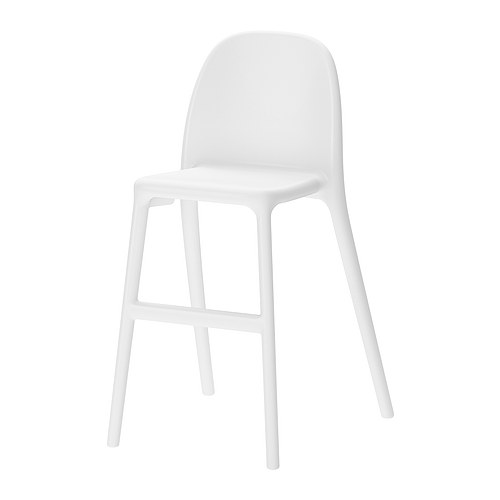

In [36]:
chair = list(data_dir.glob('chair/*'))
PIL.Image.open(str(chair[2]))

# Training / transfer learning model

In [37]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [38]:
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [39]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [40]:
batch_size = 64

preprocess_input = tf.keras.applications.vgg16.preprocess_input

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset='training',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    subset='validation',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 415 images belonging to 6 classes.
Found 99 images belonging to 6 classes.


In [41]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 7, 7, 512)
(64, 512)


In [42]:
x = base_model.output
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='fc1')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='fc2')(x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(1024, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.2*0.5)(x)
x = tf.keras.layers.Dense(6, activation='softmax')(x)
model_2 = tf.keras.Model(inputs=base_model.input, outputs=x)

In [43]:
base_learning_rate = 0.0001
model_2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_2.summary()        

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [44]:
weights_file = 'vgg16_furniture_classifier_1129.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_file, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)


In [20]:
model_2.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

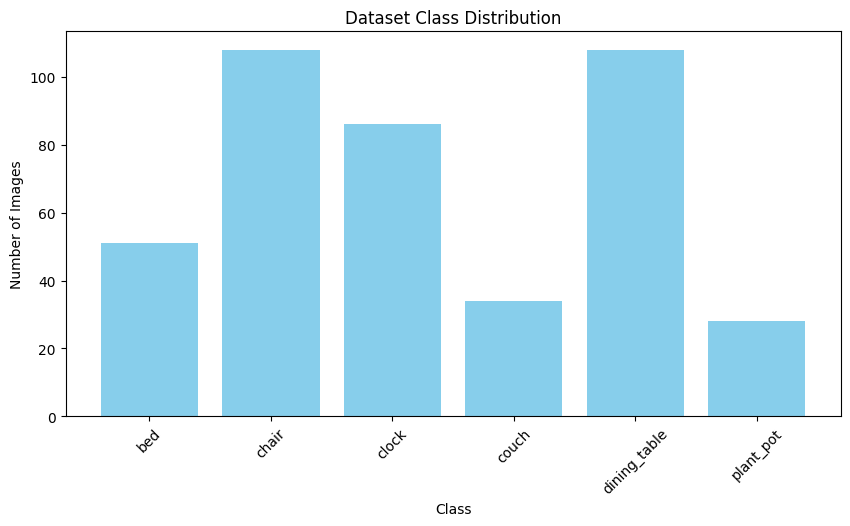

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Get class indices and labels
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

# Count the number of images per class
class_counts = np.bincount(train_generator.classes)

# 🔹 Ensure class_labels and class_counts have the same length
if len(class_labels) == len(class_counts):
    plt.figure(figsize=(10, 5))
    plt.bar(class_labels, class_counts, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title("Dataset Class Distribution")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("⚠️ Mismatch detected! Labels:", len(class_labels), "Counts:", len(class_counts))
    print("Labels:", class_labels)
    print("Counts:", class_counts)


In [46]:
history = model_2.fit(
    train_generator,
    steps_per_epoch=3110//batch_size,
    epochs=15,
    validation_data=val_generator,
    validation_steps=772//batch_size,
    verbose=1,
    workers=4,
    callbacks=[checkpoint,early,tensorboard]
)

Epoch 1/15
48/48 [==============================] - ETA: 0s - loss: 23.6085 - accuracy: 0.8117
Epoch 1: val_accuracy improved from -inf to 0.87710, saving model to vgg16_furniture_classifier_1129.h5
48/48 [==============================] - 210s 4s/step - loss: 23.6085 - accuracy: 0.8117 - val_loss: 1.1109 - val_accuracy: 0.8771
Epoch 2/15
48/48 [==============================] - ETA: 0s - loss: 0.3551 - accuracy: 0.9637
Epoch 2: val_accuracy improved from 0.87710 to 0.88721, saving model to vgg16_furniture_classifier_1129.h5
48/48 [==============================] - 346s 7s/step - loss: 0.3551 - accuracy: 0.9637 - val_loss: 1.5459 - val_accuracy: 0.8872
Epoch 3/15
48/48 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.9680
Epoch 3: val_accuracy improved from 0.88721 to 0.90909, saving model to vgg16_furniture_classifier_1129.h5
48/48 [==============================] - 208s 4s/step - loss: 0.2614 - accuracy: 0.9680 - val_loss: 0.8076 - val_accuracy: 0.9091
Epoch 4/

# Plot Accuracy and loss of model

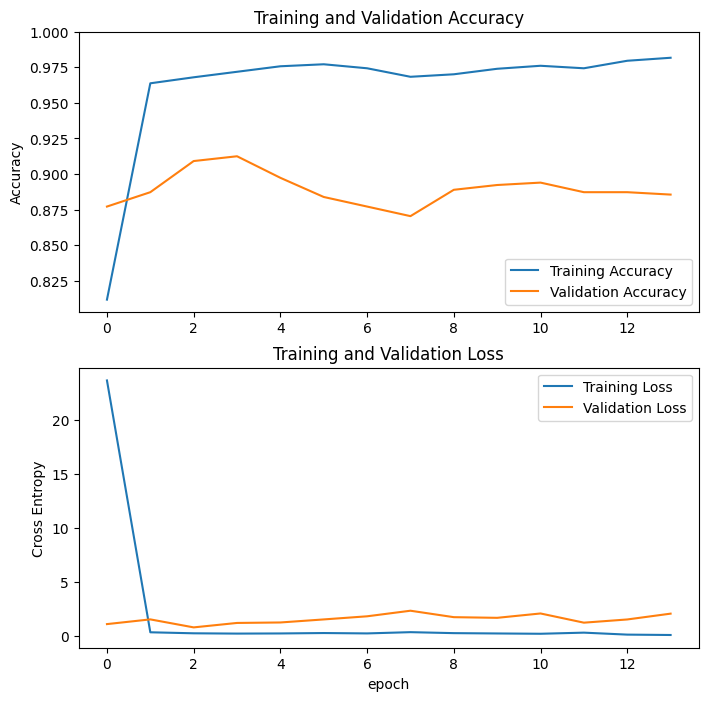

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Visualize Feature maps

In [48]:
from keras.preprocessing import image
preprocess_input = tf.keras.applications.vgg16.preprocess_input
from keras.models import Model
import numpy as np
from matplotlib import pyplot

1/1 [==============================] - 0s 393ms/step


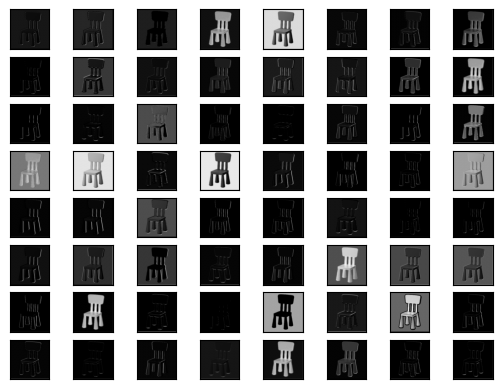

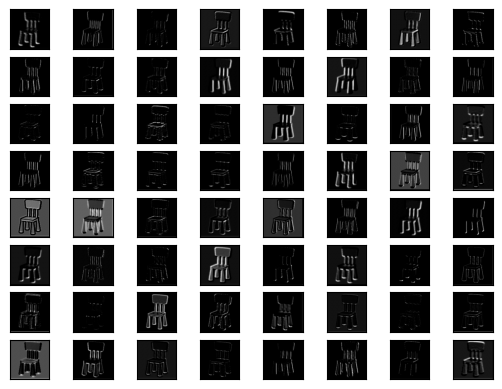

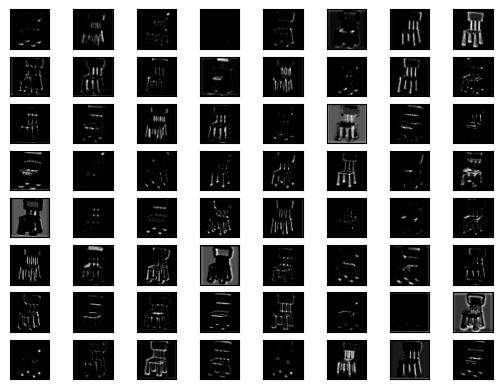

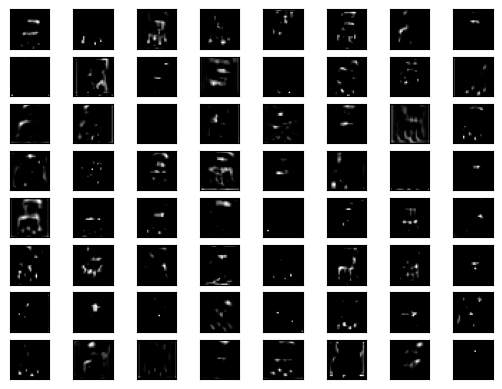

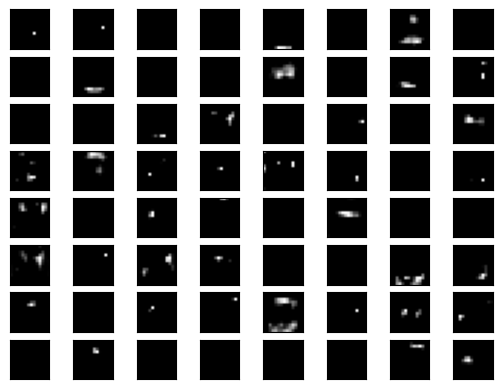

In [50]:
ixs = [2, 5, 9, 13, 17]
outputs = [model_2.layers[i].output for i in ixs]
model = Model(inputs=model_2.inputs, outputs=outputs)
img = image.load_img('C:\\Users\\krnps\\Downloads\\Deep-learning-recommender-main\\Deep-learning-recommender-main\\data\\chair\\902.675.56.jpg', target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
feature_maps = model.predict(img)
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	pyplot.show()

In [52]:
import pickle

file_path = r"C:\Users\krnps\Downloads\Deep-learning-recommender-main\Deep-learning-recommender-main\data\bed\file_mapping_bed.p"  # Use raw string (r"") to avoid path issues

try:
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    print("✅ Successfully loaded pickle file! Type of data:", type(data))
except pickle.UnpicklingError:
    print("❌ Error: This file is not a valid pickle file or is corrupted.")
except Exception as e:
    print(f"Unexpected error: {e}")


✅ Successfully loaded pickle file! Type of data: <class 'dict'>
